## Import Tensorflow and Keras dependencies

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
#to plot first 25 images of MNIST
import matplotlib.pyplot as plt
import random

print(tf.__version__)

2.9.2


## Download MNIST dataset and split into training and testing

In [ ]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


## Make sure every pixel is between 0 and 1 By normalizing the data

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Pixels are normalized


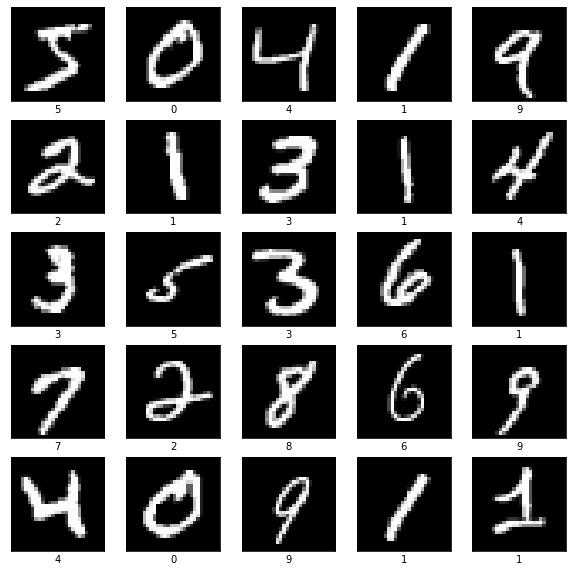

In [ ]:
#Print a part of the dataset to see if correctly loaded
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

## Train our model using basic CNN

Inout -> **a 28px x 28px grayscale image** 
Output -> **a float array of length 10** representing the probability of the image being a digit from 0 to 9.

In [ ]:
#Model Architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Dropout(0.25),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

#Extra parameters for training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 19s 4ms/step - loss: 0.1397 - accuracy: 0.9578
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0526 - accuracy: 0.9843
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0396 - accuracy: 0.9879
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0307 - accuracy: 0.9900
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0251 - accuracy: 0.9918


## Run model against the test dataset to judge accuracy


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0403 - accuracy: 0.9881
Test accuracy: 0.988099992275238


313/313 [==============================] - 1s 2ms/step


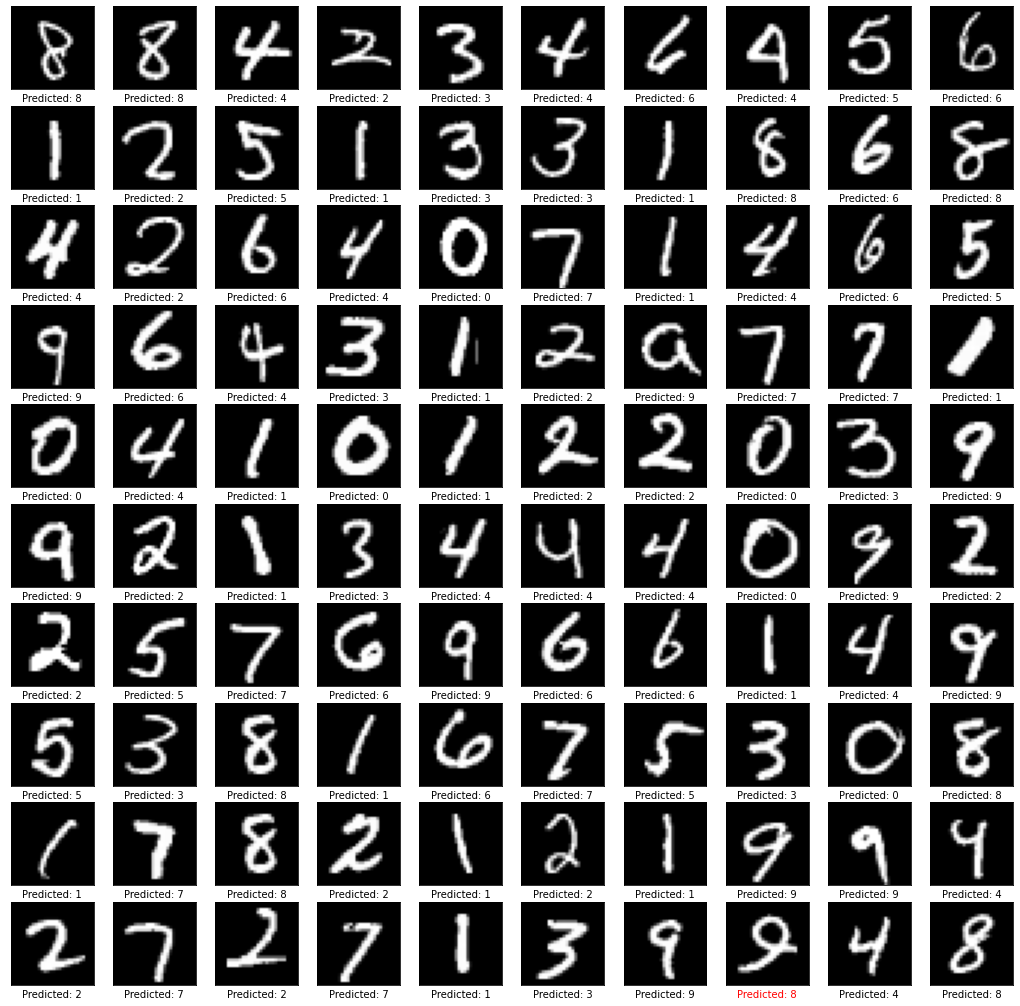

In [ ]:
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

predictions = model.predict(test_images)
prediction_digits = np.argmax(predictions, axis=1)

plt.figure(figsize=(18, 18))
for i in range(100):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],\
                                           test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

## Convert the Keras model to TensorFlow Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 437KBs.


In [ ]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 113KBs,
which is about 26% of the float model size.


## Evaluate the TensorFlow Lite model


In [ ]:
def evaluate_tflite_model(tflite_model):
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy


float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)


quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))


Float model accuracy = 0.9881
Quantized model accuracy = 0.9881
Accuracy drop = 0.0000


## Download the TensorFlow Lite model

In [ ]:
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

from google.colab import files
files.download('mnist.tflite')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`mnist.tflite` has been downloaded
